# Automated System for Solving CAPTCHAs


## Steps involved
1. **Retrieval** : Retrieve images and their corresponding labels, and store them in a list for further processing.

2. **Image Processing**: Apply advanced image processing techniques to extract maximum information from the images, enhancing their quality and optimizing them for further analysis.

3. **Efficient Segmentation**: Employ efficient algorithms to segment each image into three distinct parts, ensuring accurate separation of the three letters present in each image. Store the segmented parts in a list for subsequent analysis.

4. **Label Mapping**: Create a comprehensive mapping that associates each label with a unique number ranging from 0 to 23. This mapping will facilitate further analysis and model training.

5. **Model Training**: Utilize state-of-the-art machine learning algorithms, including Support Vector Machines (SVM), Logistic Regression, Decision Trees, and Random Forests, to train multiple models. These models will learn from the labeled image data and acquire the ability to classify new, unseen images accurately.

6. **Model Testing**: Evaluate the performance of the trained models by testing them on a separate dataset. Assess their accuracy, precision, recall, and other relevant metrics to determine the effectiveness of each model in accurately identifying and classifying the letters in the images.


## Retrieval of images and labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

In [ ]:
path = '/content/drive/MyDrive/CS771ML/train'
imageList = os.listdir(path)
imageList.remove("labels.txt")
with open("/content/drive/MyDrive/CS771ML/train/labels.txt", 'r') as file:
  Labels = file.readlines()
Labels = [line.rstrip('\n') for line in Labels]

Xtrain = []
ytrain = []

Xtest = []
ytest = []

trainRatio = 1

count = len(imageList)*trainRatio
i = 0 
for imageFile in imageList:
  if(i<count):
    #  add to train list
    Xtrain.append(imageFile)
    labelIndex = int(imageFile.split(".")[0])
    ytrain.append(Labels[labelIndex])
  else:
    Xtest.append(imageFile)
    labelIndex = int(imageFile.split(".")[0])
    ytest.append(Labels[labelIndex])
  i += 1

In [ ]:
Xtrain[:10]

['1023.png',
 '1005.png',
 '1019.png',
 '1018.png',
 '1016.png',
 '1006.png',
 '1024.png',
 '1000.png',
 '1013.png',
 '1020.png']

In [ ]:
ytrain[:10]

['ZETA,MU,CHI',
 'MU,ALPHA,PSI',
 'GAMMA,CHI,IOTA',
 'TAU,PSI,UPSILON',
 'PI,EPSILON,ALPHA',
 'OMICRON,OMEGA,DELTA',
 'ZETA,CHI,XI',
 'UPSILON,PHI,THETA',
 'IOTA,GAMMA,TAU',
 'KAPPA,IOTA,OMEGA']

## Label Mapping

In [ ]:
labelTonum = {'ALPHA' : 0,
 'BETA' : 1,
 'CHI' : 2,
 'DELTA' : 3,
 'EPSILON': 4,
 'ETA' : 5,
 'GAMMA' : 6,
 'IOTA' : 7,
 'KAPPA' : 8,
 'LAMDA': 9,
 'MU' :10,
 'NU' : 11,
 'OMEGA' : 12,
 'OMICRON':13,
 'PHI' : 14,
 'PI' : 15,
 'PSI' : 16,
 'RHO' : 17,
 'SIGMA' : 18,
 'TAU' : 19,
 'THETA' : 20,
 'UPSILON' : 21,
 'XI' : 22,
 'ZETA': 23}

In [ ]:
numTolabel = {0 : 'ALPHA',
 1: 'BETA',
 2: 'CHI',
 3: 'DELTA',
 4: 'EPSILON',
 5: 'ETA',
 6: 'GAMMA',
 7: 'IOTA',
 8: 'KAPPA',
 9: 'LAMDA',
 10: 'MU',
 11: 'NU',
 12: 'OMEGA',
 13: 'OMICRON',
 14: 'PHI',
 15: 'PI',
 16: 'PSI',
 17: 'RHO',
 18: 'SIGMA',
 19: 'TAU',
 20: 'THETA',
 21: 'UPSILON',
 22: 'XI',
 23: 'ZETA'}

## Image processing and segmentation

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [ ]:
len(Xtrain)

2000

In [ ]:
def ImgProcessing_Seg():
  for imageIndex in tqdm(range(len(Xtrain))):
    img = cv2.imread(os.path.join(path, Xtrain[imageIndex]))
    # get shape of the image
    y_dim, x_dim = img.shape[:2]

    # Find corner pixel with max freq     
    corners = np.array([img[0,0] ,img[0,-1] ,img[-1,0] ,img[-1,-1] ])
    unique, counts = np.unique(corners, axis = 0,  return_counts = True)
    backgnd = unique[np.argmax(counts)]

    # change the background to white
    background = np.where((img[:,:,0]==backgnd[0]) & (img[:,:,1]==backgnd[1]) & (img[:,:,2]==backgnd[2]))
    img[background] = np.array([255,255,255], dtype = np.uint8)

    # Now Dilate the image 
    kernel = np.ones((5, 5), np.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=1)

    # convert image to grayscale
    gray = cv2.cvtColor(img_dilation, cv2.COLOR_BGR2GRAY)

    # Segment image into 3 character
    start = True
    countPrev = 0
    mylist = []
    for i in range(500):
      vpp = np.sum(gray[:,i] < 250)
      if vpp > 12:
        if start:
          # print(i)
          temp = i
          start = False
        countPrev += 1
      if vpp == 0:
        if start == False:
          # print(i)
          if countPrev > 30:
            sizediff = i-temp
            if (sizediff < 150):
              x_temp = temp - int((150 - sizediff)/2)
              x = x_temp if x_temp > 0 else 0
              x = x if x + 150 < 500 else 350
              y = 0
            else:
              x = i
              y = 0
            mylist.append((x , y, 150, 150))
            countPrev = 0
          start = True    
    listSize = len(mylist)
    if listSize != 3 :
      mylist = [(15 , 0 , 150, 150),(175, 0, 150, 150),(335, 0, 150, 150)]

    # Got the segment of the image
    labelList = ytrain[imageIndex].split(",")
    numberLabel = []
    for labb in labelList:
      numberLabel.append(labelTonum[labb])
    for boxIndex in range(3):
      x, y = mylist[boxIndex][0], mylist[boxIndex][1]
      finalImage = gray[y:y + 150, x:x + 150]
      finalImage = cv2.resize(finalImage, (30, 30))
      finalImage = finalImage.flatten()
      dfX.append(finalImage)
      # get the labels
      dfy.append(numberLabel[boxIndex])
  return "success"

dfX = []
dfy = []
print(ImgProcessing_Seg())

 23%|██▎       | 454/2000 [00:05<00:18, 82.77it/s]

In [ ]:
len(dfy)

6000

In [ ]:
len(dfX)

6000

## Model Training

In [ ]:
import pickle
import pandas as pd

In [ ]:
########## Random Forest ##########

from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 30)
clf.fit(dfX, dfy)
y_pred = clf.predict(dfX)

from sklearn import metrics
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(dfy, y_pred))
filename = 'modelrandomForest.sav'
pickle.dump(clf, open(filename, 'wb'))

ACCURACY OF THE MODEL:  1.0


In [ ]:
########## Logistic Regression ##########

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0,max_iter=4000)
classifier.fit(dfX,dfy)
svm_predictions = classifier.predict(dfX)
count = 0
for i in range(len(svm_predictions)):
    if svm_predictions[i] == dfy[i]:
        count += 1
print("ACCURACY OF THE MODEL: ", count/(i+1)*100)
filename = 'modelLogReg.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
########## Support Vector Classifier ##########

from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1,).fit(dfX,dfy)
svm_predictions = svm_model_linear.predict(dfX)
count = 0
for i in range(len(svm_predictions)):
    if svm_predictions[i] == dfy[i]:
        count += 1
print("ACCURACY OF THE MODEL: ",count/(i+1)*100)
# filename = 'modelSVM.sav'
# pickle.dump(svm_model_linear, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

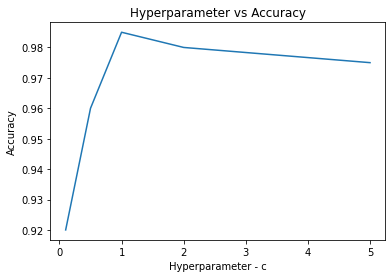

In [ ]:
# importing the required module
import matplotlib.pyplot as plt

# These data were collected using different values of C i.e. regularisation on the Train data.
myC = [0.1, 0.5, 1, 2, 5]
acc = [0.92,0.96,0.985,0.98,0.975]

plt.plot(myC, acc)
# naming the x axis
plt.xlabel('Hyperparameter - c')
# naming the y axis
plt.ylabel('Accuracy')
# giving a title to my graph
plt.title('Hyperparameter vs Accuracy')
# function to show the plot
plt.show()

## Evaluating the model

In [ ]:
def predictTest():
  for imageIndex in tqdm(range(len(Xtest))):
    img = cv2.imread(os.path.join(path, Xtest[imageIndex]))
    # get shape of the image
    y_dim, x_dim = img.shape[:2]
    
    # Find corner pixel with max freq     
    corners = np.array([img[0,0] ,img[0,-1] ,img[-1,0] ,img[-1,-1] ])
    unique, counts = np.unique(corners, axis = 0,  return_counts = True)
    backgnd = unique[np.argmax(counts)]

    # change the background to white
    background = np.where((img[:,:,0]==backgnd[0]) & (img[:,:,1]==backgnd[1]) & (img[:,:,2]==backgnd[2]))
    img[background] = np.array([255,255,255], dtype = np.uint8)

    # Now Dilate the image 
    kernel = np.ones((5, 5), np.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=1)

    # convert image to grayscale
    gray = cv2.cvtColor(img_dilation, cv2.COLOR_BGR2GRAY)

    # Segment image into 3 characters 
    # Get the cordinates of the bounding box of each character
    start = True
    countPrev = 0
    mylist = []
    for i in range(500):
      vpp = np.sum(gray[:,i] < 250)
      if vpp > 12:
        if start:
          # print(i)
          temp = i
          start = False
        countPrev += 1
      if vpp == 0:
        if start == False:
          # print(i)
          if countPrev > 30:
            sizediff = i-temp
            if (sizediff < 150):
              x_temp = temp - int((150 - sizediff)/2)
              x = x_temp if x_temp > 0 else 0
              x = x if x + 150 < 500 else 350
              y = 0
            else:
              x = i
              y = 0
            mylist.append((x , y, 150, 150))
            countPrev = 0
          start = True    
    listSize = len(mylist)
    if listSize != 3 :
      mylist = [(15 , 0 , 150, 150),(175, 0, 150, 150),(335, 0, 150, 150)]
      # print(mylist)
      # print(imageFile)
      # print(listSize)
      # print(mylist)
      # print(vpp)
      # return "failed"

    # Got the segment of the image
    labelList = ytest[imageIndex].split(",")
    numberLabel = []
    for labb in labelList:
      numberLabel.append(labelTonum[labb])
    for boxIndex in range(3):
      x, y = mylist[boxIndex][0], mylist[boxIndex][1]
      finalImage = gray[y:y + 150, x:x + 150]
      finalImage = cv2.resize(finalImage, (30, 30))
      finalImage = finalImage.flatten()
      dfXtest.append(finalImage)
      # get the labels
      dfytest.append(numberLabel[boxIndex])
  return "success"

dfXtest = []
dfytest = []
print(predictTest())

100%|██████████| 1000/1000 [00:45<00:00, 21.88it/s]

success


In [ ]:
len(dfXtest)

1200

In [ ]:
svm_predictions = svm_model_linear.predict(dfXtest)
count = 0
for i in range(len(svm_predictions)):
    if svm_predictions[i] == dfytest[i]:
        count += 1
print(count/(i+1)*100)

97.08333333333333


In [ ]:
# So the final accuracy on the test data that was achieved was 97.08%

## Below are some test processing that I used for the project.

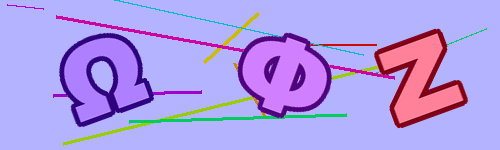

In [ ]:
img1 = cv2.imread(os.path.join(path, Xtrain[1002]))
cv2_imshow(img1)

In [ ]:
%%timeit
for i in range(y_dim):
  for j in range(x_dim):
    if all(img1[i][j]==img_temp):
      img1[i][j] = np.array([255,255,255],dtype=np.uint8)

64.6 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


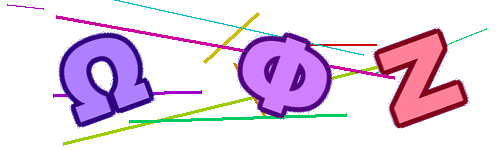

In [ ]:
# %%timeit 
# img = img1.copy()
background = np.where((img1[:,:,0]==backgnd[0]) & (img1[:,:,1]==backgnd[1]) & (img1[:,:,2]==backgnd[2]))
img1[background] = np.array([255,255,255], dtype= np.uint8)
cv2_imshow(img1)

In [ ]:
black

(array([], dtype=int64), array([], dtype=int64))

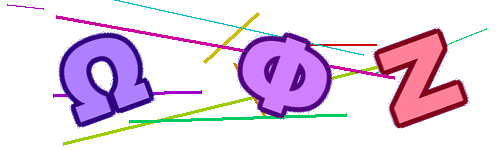

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img1)

In [ ]:
kernel = np.ones((5, 5), np.uint8)
img_erosion = cv2.erode(img1, kernel, iterations=1)
img_dilation = cv2.dilate(img1, kernel, iterations=1)

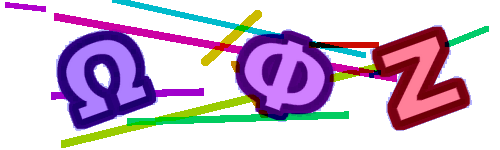

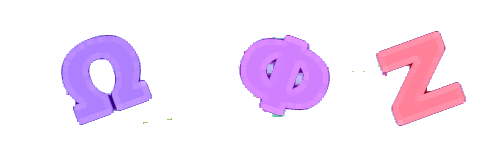

In [ ]:
from google.colab.patches import cv2_imshow
# cv2_imshow(img_erosion)
cv2_imshow(img_dilation)
# cv2.imwrite("/content/drive/MyDrive/CS771ML/myimage.jpg", img_dilation)

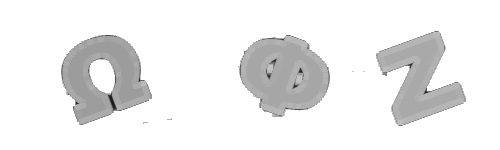

In [ ]:
gray = cv2.cvtColor(img_dilation, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

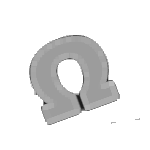

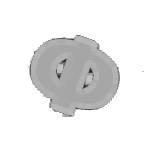

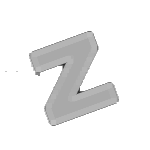

In [ ]:
start = True
countPrev = 0
mylist = []
for i in range(500):
  vpp = np.sum(gray[:,i] < 250)
  if vpp > 12:
    if start:
      # print(i)
      temp = i
      start = False
    countPrev += 1
  if vpp == 0:
    if start == False:
      # print(i)
      if countPrev > 30:
        sizediff = i-temp
        if (sizediff < 150):
          x_temp = temp - int((150 - sizediff)/2)
          x = x_temp if x_temp > 0 else 0
          x = x if x + 150 < 500 else 350
          y = 0
        else:
          x = i
          y = 0
        mylist.append((x , y, 150, 150))
        countPrev = 0
      start = True    
listSize = len(mylist)
if listSize != 3 :
  mylist = [(15 , 0 , 150, 150),(175, 0, 150, 150),(335, 0, 150, 150)]

for boxx in range(3): 
  x, y = mylist[boxx][0], mylist[boxx][1]
  finalImage = gray[y:y + 150, x:x + 150]
  # finalImage = cv2.resize(finalImage, (30, 30))
  cv2_imshow(finalImage)
# finalImage = finalImage.flatten()
# dfXtest.append(finalImage)
# get the labels

In [ ]:
np.sum(gray[:,55] < 250)

3

In [ ]:
gray[:,0] = 0
gray[:,12] = 0

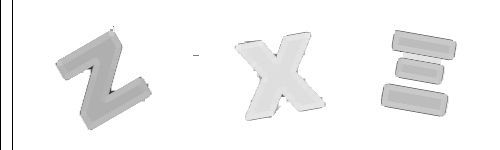

In [ ]:
cv2_imshow(gray)

In [ ]:
start = True
countPrev = 0
mylist = []
for i in range(500):
  vpp = np.sum(gray[:,i] < 250)
  if vpp > 10:
    if start:
      # print(i)
      temp = i
      start = False
    countPrev += 1
    
  if vpp == 0:
    if start == False:
      # print(i)
      if countPrev > 40:
        mylist.append((temp,i))
        countPrev = 0
      start = True
  
mylist

[(61, 152), (240, 330), (378, 466)]

In [ ]:
start = 420
sizediff = 60
x_temp = start - int((150 - sizediff )/2) 
x = x_temp if x_temp > 0 else 0
x = x if x + 150 < 500 else 350
x

350

In [ ]:
%%timeit

def getsegment(start, end):
  sizediff = end-start
  if (sizediff < 150):
    x_temp = start - int((150 - sizediff)/2)
    x = x_temp if x_temp > 0 else 0
    x = x if x + 150 < 500 else 350
    y = 0
  return x, y, 150, 150

start = True
countPrev = 0
mylist = []
for i in range(500):
  vpp = np.sum(gray[:,i] < 250)
  if vpp > 12:
    if start:
      # print(i)
      temp = i
      start = False
    countPrev += 1
  if vpp == 0:
    if start == False:
      # print(i)
      if countPrev > 30:
        x , y, h, w = getsegment(temp, i)
        mylist.append((x,y,h,w))
        countPrev = 0
      start = True    
listSize = len(mylist)
if listSize != 3 :
  letter_image_regions = [(15 , 0 , 150, 150),(175, 0, 150, 150),(335, 0, 150, 150)]
# print(mylist)

3.61 ms ± 96.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


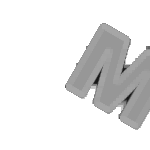

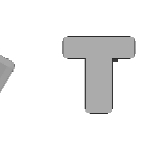

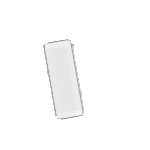

In [ ]:
# Dividing the image in 3

letter_image_regions = [(15 , 0 , 150, 150),(175, 0, 150, 150),(335, 0, 150, 150)]
for letter_bounding_box in letter_image_regions:
  x, y, w, h = letter_bounding_box
  letter_image = gray[y:y + h, x:x + w]
  cv2_imshow(letter_image)
  # p = os.path.join('/content', letter_text+".png")
  # cv2.imwrite(p, letter_image)

In [ ]:
ret3, th3 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
inverted = cv2.bitwise_not(th3)
vpp = np.sum(inverted, axis=0)

In [ ]:
vpp

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,   255,  1020,  1530,  2550,  3060,  3570,  4335,  4845,
        5355,  5610,  6120,  6375,  6375,  6630,  6630,  6630,  6375,
        6630,  6630,  6630,  6630,  6630,  6630,  6630,  6885,  8160,
        9435, 11220, 11985, 13515, 15045, 16320, 18105, 19380, 21165,
       22440, 22695, 22950, 22695, 22950, 22695, 22695, 22695, 22695,
       22950, 22695, 22950, 22695, 22695, 22950, 22695, 22950, 22695,
       22950, 22695, 22950, 22950, 20910, 19635, 18105, 16830, 15300,
       14280, 12750, 11475,  9945,  8670,  6630,  6630,  6630,  6630,
        6630,  6630,

In [ ]:
start = True
countPrev = 0
mylist = []
for i in range(len(vpp)):
  if vpp[i] > 10:
    if start:
      # print(i)
      temp = i
      start = False
    countPrev += 1
    
  if vpp[i] == 0:
    if start == False:
      # print(i)
      if countPrev > 40:
        mylist.append((temp,i))
        countPrev = 0
      start = True
  
mylist

[(80, 190), (237, 311), (378, 419)]

In [ ]:
start = True
mylist = []
for i in range(len(vpp)):
  if vpp[i] > 10 and start:
    # print(i)
    temp = i
    start = False
  if vpp[i] == 0 and start == False:
    # print(i)
    mylist.append((temp,i))
    start = True
mylist

[(80, 190), (237, 311), (378, 419)]

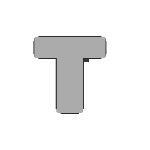

In [ ]:
letter_image_regions = [(70 , 0 , 150, 150),(204, 0, 150, 150),(335, 0, 150, 150)]
x, y, w, h = letter_image_regions[1]
letter_image = gray[y:y + h, x:x + w]
cv2_imshow(letter_image)

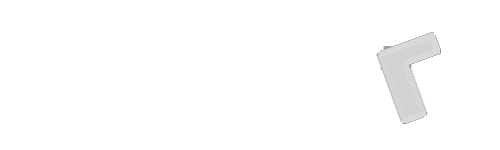

In [ ]:
segment = gray.copy()
segment[segments!=index] = 255
cv2_imshow(segment)